## Fine-tune TrOCR on the IAM Handwriting Database

In this notebook, we are going to fine-tune a pre-trained TrOCR model on the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), a collection of annotated images of handwritten text.

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text. 

This figure gives a good overview of the model (from the original paper):

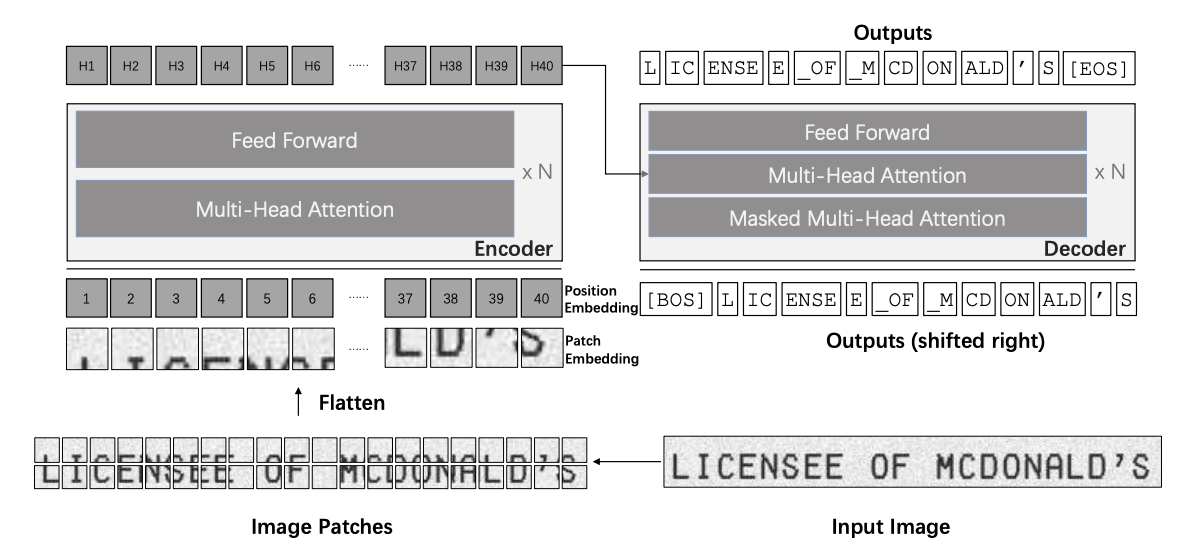

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook. 

We will fine-tune the model using native PyTorch.



## Set-up environment

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)

We will not be using HuggingFace Datasets in this notebook for data preprocessing, we will just create a good old basic PyTorch Dataset.

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.2 MB 30.6 MB/s 
     |████████████████████████████████| 6.6 MB 56.4 MB/s 
     |████████████████████████████████| 596 kB 52.9 MB/s 
     |████████████████████████████████| 86 kB 5.2 MB/s 


In [ ]:
!pip install -q datasets jiwer

     |████████████████████████████████| 346 kB 18.3 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.4 MB/s 
     |████████████████████████████████| 140 kB 75.1 MB/s 
     |████████████████████████████████| 212 kB 62.8 MB/s 
     |████████████████████████████████| 127 kB 70.8 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 271 kB 57.2 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 75.4 MB/s 
     |████████████████████████████████| 112 kB 68.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!gdown 1NSzSUdXXhK8exFlrSUcLwjBicLLCjt6q

Downloading...
From: https://drive.google.com/uc?id=1NSzSUdXXhK8exFlrSUcLwjBicLLCjt6q
To: /content/Label.rar
100% 1.16M/1.16M [00:00<00:00, 54.3MB/s]


In [ ]:
!unrar x '/content/Label.rar'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Extracting  Label/20151113_0052_25464_1_tg_0_0.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_0_1.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_0_2.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_0_3.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_0_4.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_0_5.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_0_6.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_0_7.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_1_0.txt                        31%  OK 
Extracting  Label/20151113_0052_25464_1_tg_1_1.txt                        31%  OK 
Extracting  Label/20151

In [ ]:
!gdown 1cOOJGVmxVo1evTU9xQdSbztFmeFXTwif

Downloading...
From: https://drive.google.com/uc?id=1cOOJGVmxVo1evTU9xQdSbztFmeFXTwif
To: /content/Feature_Img.rar
100% 59.6M/59.6M [00:00<00:00, 76.0MB/s]


In [ ]:
!unrar x '/content/Feature_Img.rar'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Extracting  Feature_Img/20151113_0052_25464_1_tg_0_0.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_0_1.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_0_2.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_0_3.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_0_4.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_0_5.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_0_6.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_0_7.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_1_0.png                  31%  OK 
Extracting  Feature_Img/20151113_0052_25464_1_tg_1_1.png                  31%  OK 
Extracting  Feature_Img

# Ko chay muc nay

In [ ]:
!gdown 1e9M_3u22nxF8yUGbiAgNvVkAoqFAdu09

Downloading...
From: https://drive.google.com/uc?id=1e9M_3u22nxF8yUGbiAgNvVkAoqFAdu09
To: /content/pytorch_model.rar
100% 1.43G/1.43G [00:15<00:00, 91.8MB/s]


In [ ]:
!unrar x '/content/pytorch_model.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/pytorch_model.rar

Extracting  pytorch_model.bin                                              0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%  OK 
All

In [ ]:
!gdown 10gtBzC9immOsxKUGWfwCXN8CR2mWkqwk

Downloading...
From: https://drive.google.com/uc?id=10gtBzC9immOsxKUGWfwCXN8CR2mWkqwk
To: /content/config.json
100% 4.62k/4.62k [00:00<00:00, 7.49MB/s]


# Chay ne

In [ ]:
!gdown 1--8tH4n7uaNRjMNuystmbA7AVjrS8Nkf

Downloading...
From: https://drive.google.com/uc?id=1--8tH4n7uaNRjMNuystmbA7AVjrS8Nkf
To: /content/pytorch_model.bin
100% 1.54G/1.54G [00:28<00:00, 53.6MB/s]


In [ ]:
from google.colab import drive
drive.mount( '/content/gdrive' )

Mounted at /content/gdrive


In [ ]:
!gdown 1--UjH40giaoFbNCDRNd_LXu9q0o46nlH

Downloading...
From: https://drive.google.com/uc?id=1--UjH40giaoFbNCDRNd_LXu9q0o46nlH
To: /content/config.json
100% 4.62k/4.62k [00:00<00:00, 8.11MB/s]


In [ ]:
!gdown 1--FFiG6MtnRG5onozhSW2z3Q-oG0Q4m7

Downloading...
From: https://drive.google.com/uc?id=1--FFiG6MtnRG5onozhSW2z3Q-oG0Q4m7
To: /content/train_df.csv
100% 678k/678k [00:00<00:00, 122MB/s]


In [ ]:
!gdown 101Ej37U8SiEjrBqGxWNtWfMPL296RgZe

Downloading...
From: https://drive.google.com/uc?id=101Ej37U8SiEjrBqGxWNtWfMPL296RgZe
To: /content/test_df.csv
100% 227k/227k [00:00<00:00, 96.8MB/s]


## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr). 

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [ ]:
import pandas as pd

df = pd.read_fwf('/content/drive/MyDrive/TrOCR/Tutorial notebooks/IAM/gt_test.txt', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
del df[2]
# some file names end with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

In [ ]:
Labels=[]
label_path='/content/Label'
from PIL import Image
import numpy as np
import cv2
import os
import pandas as pd

i=0
for label in os.listdir(label_path):
  my_tring=label[:-4]
  the_string=my_tring+'.png'
  file1 = open(os.path.join(label_path,label), "r")
  FileContent = file1.read()
  file1.close()
  if len(FileContent)<128:
    Labels.append([the_string,str(FileContent)])
  print(i)
  i=i+1
df = pd.DataFrame(Labels, columns =['file_name', 'text'])
df.head()

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
247

,file_name,text
0,20151214_0065_26558_2_tg_2_0.png,"Ông nói thêm : "" Trước đây TP là trung tâm phâ..."
1,20160517_0139_9129_2_tg_3_5.png,"bị chấn thương, nhưng tất cả họ đều bị chết ng..."
2,20160722_0201_26749_2_tg_1_2.png,"trả lời Chiều 31 - 3, Cơ quan cảnh sát điều tr..."
3,20160426_0104_25480_tg_3_1.png,TP.HCM thành lập hội đồng giám định xây dựng c...
4,20140927_0018_5770_3_tg_3_2.png,"chiêu "" này, nạn nhân gà chỉ còn cách nằm bẹp ..."


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.25)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import pandas as pd
train_df=pd.read_csv('/content/train_df.csv')
test_df=pd.read_csv('/content/test_df.csv')

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='/content/drive/MyDrive/TrOCR/Tutorial notebooks/IAM/image/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/drive/MyDrive/TrOCR/Tutorial notebooks/IAM/image/',
                           df=test_df,
                           processor=processor)

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='/content/Feature_Img/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/Feature_Img/',
                           df=test_df,
                           processor=processor)

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("/content/pytorch_model.bin", config="/content/config.json")

# load image from the IAM dataset
url = "/content/Feature_Img/20160119_0074_26554_2_tg_0_6.png"
image = Image.open(url).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
pixel_values.size()

torch.Size([1, 3, 384, 384])

In [ ]:
print(pixel_values[0][1][12])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
print(pixel_values)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])


In [ ]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

In [ ]:
generated_text

'có nguyện vậy được với và n'

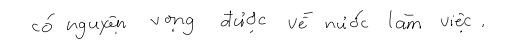

In [ ]:
image

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 5460
Number of validation examples: 1821


Let's verify an example from the training dataset:

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [ ]:
encoding

{'labels': tensor([    0,   487,  4147,  1376,  2023,  6382,   660,    43,   295,  1376,
          3070, 15389,   119,  2664,  1657,   579,  1376,  2023,  3602,   579,
          1526,   257,  6094,  8188,  7487,  1376,  2023,    46,   118,   741,
          1376,  2023, 13859,   741,  1376,  3070, 10965,    90,     6,   753,
          6094,  5269,   219,  4236,  3602,  8188,  7487,  1376,  2023,  2469,
           438,  1855,   257,  1376,  2023,    27,   438, 15642, 16447,  1376,
          2023,  9357,   118,   326,  3849,  9253,     4,     2,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100

We can also check the original image and decode the labels:

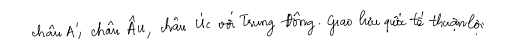

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
print(labels)
labels[labels == -100] = processor.tokenizer.pad_token_id
print(labels)
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

tensor([    0,   487,  4147,  1376,  2023,  6382,   660,    43,   295,  1376,
         3070, 15389,   119,  2664,  1657,   579,  1376,  2023,  3602,   579,
         1526,   257,  6094,  8188,  7487,  1376,  2023,    46,   118,   741,
         1376,  2023, 13859,   741,  1376,  3070, 10965,    90,     6,   753,
         6094,  5269,   219,  4236,  3602,  8188,  7487,  1376,  2023,  2469,
          438,  1855,   257,  1376,  2023,    27,   438, 15642, 16447,  1376,
         2023,  9357,   118,   326,  3849,  9253,     4,     2,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

Let's create corresponding dataloaders:

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()
torch.cuda.device_count()
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model = VisionEncoderDecoderModel.from_pretrained("/content/pytorch_model.bin", config="/content/config.json")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.device_count()

1

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 3

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")
wer_metric = load_metric("wer")

In [ ]:
def compute_wer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return wer

In [ ]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(1):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1365 [00:00<?, ?it/s]

Loss after epoch 0: 0.5633565405786256


  0%|          | 0/456 [00:00<?, ?it/s]

Validation CER: 0.5956022485948008


In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(2):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
  #  # evaluate
  #  model.eval()
  #  valid_cer = 0.0
  #  with torch.no_grad():
  #    for batch in tqdm(eval_dataloader):
  #      # run batch generation
  #      outputs = model.generate(batch["pixel_values"].to(device))
  #      # compute metrics
  #      cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
  #      valid_cer += cer 

  #  print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 0: 0.3762009337348086


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 1: 0.31786172230500254


In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-7)

for epoch in range(2):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 0: 0.08374808844326181


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 1: 0.07381431548958467


In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(2):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 0: 0.286832579952906


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 1: 0.14600817082479792


In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=1e-6)

for epoch in range(3):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 0: 0.9081361902056816


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 1: 0.5036006419105377


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 2: 0.3767383494148492


In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=1e-6)

for epoch in range(1):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 0: 0.30070133871599314


In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=1e-6)

for epoch in range(3):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-8)

for epoch in range(2):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
   

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 0: 0.08935049601651913


  0%|          | 0/683 [00:00<?, ?it/s]

Loss after epoch 1: 0.08581889053673032


In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

    
   # evaluate
model.eval()
valid_cer = 0.0
valid_wer=0.0
with torch.no_grad():
  for batch in tqdm(eval_dataloader):
       # run batch generation
    outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
    cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
    valid_cer += cer
    wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
    valid_wer += wer 

print("Validation CER:", valid_cer / len(eval_dataloader))
print("Validation WER:", valid_wer / len(eval_dataloader))

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/228 [00:00<?, ?it/s]

Validation CER: 0.060357639245149794
Validation WER: 0.1446408076416849


In [ ]:
!mv "/content/Saved_model/config.json" "/content/gdrive/MyDrive/S_Model_8"

In [ ]:
model.save_pretrained("/content/Saved_model")

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# model = VisionEncoderDecoderModel.from_pretrained("/content/Saved_model/pytorch_model.bin", config="/content/Saved_model/config.json")
model = VisionEncoderDecoderModel.from_pretrained("/content/pytorch_model.bin", config="/content/config.json")

# load image from the IAM dataset
url = "/content/Feature_Img/20160119_0074_26554_2_tg_0_6.png"
image = Image.open(url).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
generated_text

'có nguyện vọng được v� nứa làm viỆc.'

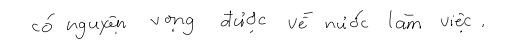

In [ ]:
image

In [ ]:
# load image from the IAM dataset
url = "/content/Feature_Img/20140603_0004_BCCTC_tg_0_4.png"
image = Image.open(url).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
generated_text

'Vậy thì bạn hãy dành chút thời gian để lặng mình suy ngẫm.'

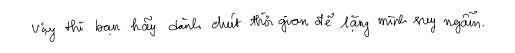

In [ ]:
image

In [ ]:
# load image from the IAM dataset
url = "/content/Feature_Img/20140603_0004_KQBDVN_tg_0_0.png"
image = Image.open(url).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
generated_text

'KHÁI QUÁT VỀ BIỂN ĐẢO VIỆT NAM'

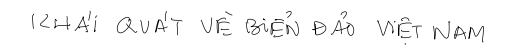

In [ ]:
image

In [ ]:
# load image from the IAM dataset
url = "/content/Feature_Img/20140603_0015_BCCTC_tg_2_0.png"
image = Image.open(url).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
generated_text

'Thành công còn là hình ảnh một c�'

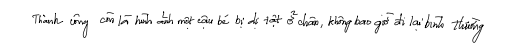

In [ ]:
image